In [3]:
import pandas as pd
import numpy as np
import seaborn as sb
import sklearn
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 10, 8
from sklearn.model_selection import train_test_split as tts
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (classification_report,confusion_matrix, roc_auc_score, accuracy_score)
from sklearn import metrics
import scikitplot as skp
import graphviz as gv

In [91]:
#load data
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')
sub = pd.read_csv('data/sample_submission.csv')
#peak through the data
train_df.head()


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [72]:
#print shape and data info
print(train_df.shape)
train_df.info()

(8693, 14)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [73]:
#check for null values
train_df.isna().any()

PassengerId     False
HomePlanet       True
CryoSleep        True
Cabin            True
Destination      True
Age              True
VIP              True
RoomService      True
FoodCourt        True
ShoppingMall     True
Spa              True
VRDeck           True
Name             True
Transported     False
dtype: bool

In [74]:
#count null values
train_df.isna().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

In [75]:
#fill in values for null 
train_df.fillna(method = 'ffill',inplace = True)
train_df.fillna(method = 'bfill',inplace = True)

test_df.fillna(method = 'ffill',inplace = True)
test_df.fillna(method = 'bfill',inplace = True)

train_df.isna().sum()

PassengerId     0
HomePlanet      0
CryoSleep       0
Cabin           0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
Name            0
Transported     0
dtype: int64

In [76]:
#Split independent and dependent
X = train_df.iloc[:,:13]
Y = train_df.iloc[:,13:14]
Y.head()

,Transported
0,False
1,True
2,False
3,False
4,True


<AxesSubplot:>

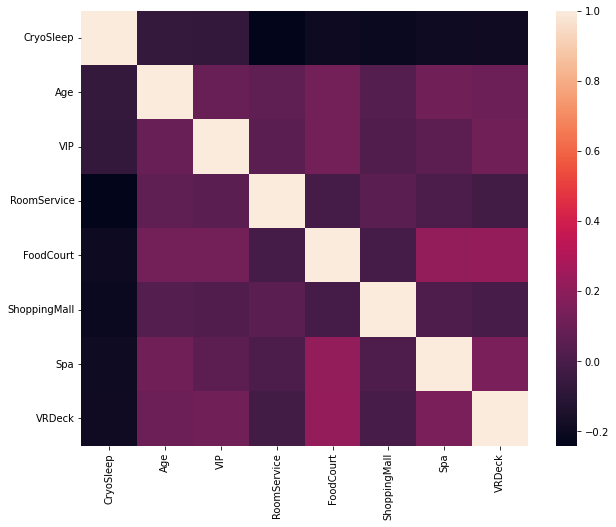

In [77]:
#check for correlation 
sb.heatmap(X.corr())

In [78]:
#DROP VR_DECK AND CRYOSLEEPER
X.drop(['VRDeck','CryoSleep'] , axis = 1 , inplace = True)
test_df.drop(['VRDeck','CryoSleep'] , axis = 1 , inplace = True)
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8693 non-null   object 
 2   Cabin         8693 non-null   object 
 3   Destination   8693 non-null   object 
 4   Age           8693 non-null   float64
 5   VIP           8693 non-null   bool   
 6   RoomService   8693 non-null   float64
 7   FoodCourt     8693 non-null   float64
 8   ShoppingMall  8693 non-null   float64
 9   Spa           8693 non-null   float64
 10  Name          8693 non-null   object 
dtypes: bool(1), float64(5), object(5)
memory usage: 687.8+ KB


In [79]:
#prepare data for model
Y['Transported'] = Y['Transported'].map({False:0,True:1})
X['VIP'] = X['VIP'].map({False:0,True:1})
test_df['VIP'] = test_df['VIP'].map({False:0,True:1})
cat_columns = ['PassengerId','HomePlanet','Cabin','Destination','Name']
num_columns = ['Age','RoomService','FoodCourt','ShoppingMall','Spa']

In [80]:
#transform categorial features
d_obj = lambda array : pd.DataFrame(array)
cat_encoder = preprocessing.LabelEncoder()
for cat in cat_columns:
    X[cat] = cat_encoder.fit_transform(X[cat])
    test_df[cat] = cat_encoder.fit_transform(test_df[cat])
#normalise numerial data
num_encoder = StandardScaler()
for num in num_columns:
    num_encoder.fit(d_obj(X[num]))
    X[num] = num_encoder.transform(d_obj(X[num]))
    test_df[num] = num_encoder.transform(d_obj(test_df[num]))
    
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   int32  
 1   HomePlanet    8693 non-null   int32  
 2   Cabin         8693 non-null   int32  
 3   Destination   8693 non-null   int32  
 4   Age           8693 non-null   float64
 5   VIP           8693 non-null   int64  
 6   RoomService   8693 non-null   float64
 7   FoodCourt     8693 non-null   float64
 8   ShoppingMall  8693 non-null   float64
 9   Spa           8693 non-null   float64
 10  Name          8693 non-null   int32  
dtypes: float64(5), int32(5), int64(1)
memory usage: 577.4 KB


In [81]:
#take only values from dataframe
x_train = X.values
y_train = Y.values
x_test = test_df.values
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   4277 non-null   int32  
 1   HomePlanet    4277 non-null   int32  
 2   Cabin         4277 non-null   int32  
 3   Destination   4277 non-null   int32  
 4   Age           4277 non-null   float64
 5   VIP           4277 non-null   int64  
 6   RoomService   4277 non-null   float64
 7   FoodCourt     4277 non-null   float64
 8   ShoppingMall  4277 non-null   float64
 9   Spa           4277 non-null   float64
 10  Name          4277 non-null   int32  
dtypes: float64(5), int32(5), int64(1)
memory usage: 284.1 KB


In [82]:
#build the model and train
model = RandomForestClassifier(max_depth = 5,
                              n_estimators = 100,
                              max_features = 4)
model.fit(X,Y)

C:\Users\admin\AppData\Local\Temp\ipykernel_10224\1131797322.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X,Y)


RandomForestClassifier(max_depth=5, max_features=4)

C:\Users\admin\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using

<AxesSubplot:title={'center':'Learning Curve'}, xlabel='Training examples', ylabel='Score'>

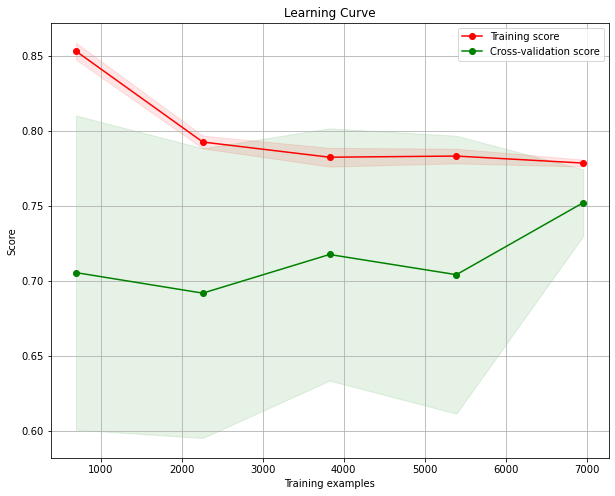

In [83]:
#make prediction
y_pred = model.predict(x_test)
skp.estimators.plot_learning_curve(model,x_train,y_train)

In [92]:
sub['Transported'] = pd.Series(y_pred).map({0:False,1:True})

In [93]:
sub.to_csv('data/submission.csv',index =False)